# Daily stressors 

The predictor "daily stressors" consists of 31 features and 67 observations.  The measurement was made by ordinal scale. Encoding method says to assign the following numbers for each answered item. 

- 1 = “Not at all” 
- 2 = “A little” 
- 3 = “Quite a bit” 
- 4 = “Extremely”. 

(Lest them forget: Daily-stressors is on “daily stressors” sheet in AV:FO columns. It consists of 31 ordinal variables of 4 levels.) 

# Depression 

A Criteria "Depression" is calculated according to the "DSM IV Depression Score" formula. The formula is in the "HOPKINS SYMPTOM CHECKLIST-25" method. 

(Lest them forget: Depression is on HSCL-25 sheet in MI:OL columns and called “DSM IV” (it is not correct). It consists of 14 ordinal variables of 4 levels.) 

In [927]:
import math
# Imports
from os.path import join, expanduser

import matplotlib
import seaborn
import sklearn
import statsmodels
from matplotlib.pyplot import ylabel, xlabel, title, xticks, yticks
from pandas import DataFrame, read_excel, options
from scipy.stats import f
from seaborn import color_palette
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
# from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
# https://habr.com/ru/articles/279117/#_=_

# Let's import data
Gather Data and check for duplicates

In [928]:
# Gather Data
io: str = join(expanduser('~'), "Documents", "Data_Emigrant Study and APA.xlsx")

outcome: DataFrame = read_excel(io=io, sheet_name='HSCL-25', header=0, index_col=0, usecols="A,KS", skiprows=[1])
y: DataFrame = outcome

predictors: DataFrame = read_excel(io=io,
                                   sheet_name='daily stressors',
                                   header=0,
                                   index_col=0,
                                   usecols="A, AV, AZ, BD, BH, BL, BP, BT, BX, CB, CF, CJ, CN, CR, CV, CZ, DD, DH, DL, DP, DT, DX, EB, EF, EJ, EN, ER, EV, EZ, FD, FH, FL",
                                   skiprows=[1])
X: DataFrame = predictors

X = X.dropna(axis="rows", how="any")
# X.columns = X.columns.str.extract('/(.*)')
y: DataFrame = y.dropna(axis="rows", how="any")

# Checking for duplicates, It is important!
print(f"Number of duplicates X: {X[X.index.duplicated(keep=False)].shape[0]}")
print(f"Number of duplicates y: {y[y.index.duplicated(keep=False)].shape[0]}")

y: DataFrame = y[y.index.isin(X.index)]
X: DataFrame = X[X.index.isin(y.index)]

Number of duplicates X: 0
Number of duplicates y: 0


# Visualize data

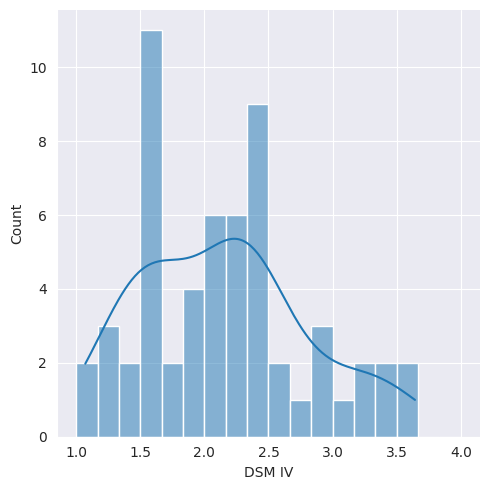

In [929]:
min_y: int = math.floor(y["DSM IV"].min())
max_y: int = math.ceil(y["DSM IV"].max())
seaborn.displot(y["DSM IV"], bins=(max_y - min_y) * 6, kde=True, binrange=(min_y, max_y))

We can see that the distribution is not normal. It is skewed to the left.

## Pairwise correlation of columns.

In [930]:
matplotlib.pyplot.figure(figsize=(60, 60))
xticks(rotation=90, fontsize=20)
yticks(fontsize=20)
seaborn.heatmap(X.corr(), annot=True, fmt='.1f', cmap=color_palette("coolwarm"), vmin=-1, vmax=1, annot_kws={"size": 20})

<Axes: >

In [931]:
X["Я чувствую вину за то, что я оставил свою семью. / I feel guilty for having left my family."].corr(X["Я чувствую как будто я бросил свою семью. / I feel like I have abandoned my family."])

0.8300419850644286

Multicollinearity!! We can see that some features are highly correlated. It is not good. Let's remove one of the features. 
Я чувствую как будто я бросил свою семью. **≠** I feel like I have abandoned my family.
Wrong translation

In [932]:
X.drop(labels="Я чувствую как будто я бросил свою семью. / I feel like I have abandoned my family.", axis="columns", inplace=True)

In [933]:
# https://habr.com/ru/articles/279117/
# let add constant to X for intercept calculation
X_incl_const: DataFrame = add_constant(data=X)
# let create model for  Ordinary Least Squares (OLS)
model: statsmodels.regression.linear_model.OLS = statsmodels.regression.linear_model.OLS(endog=y, exog=X_incl_const)
# let fit model
results: statsmodels.regression.linear_model.RegressionResultsWrapper = model.fit()

**Let's check whether the model is correct?**

In [934]:
# https://medium.com/analytics-vidhya/f-statistic-understanding-model-significance-using-python-c1371980b796
print(f"Coefficient of determination: {round(results.rsquared_adj, 2)}")  # Adjusted R-squared
print(f"F-statistic: {round(results.fvalue, 2)}")  # F-statistic
alphaValue = 0.05
print(f"F-critical: {round(f.ppf(q=1 - alphaValue, dfn=results.df_model, dfd=results.df_resid), 2)}")  # F-critical
print(f"p-value (F-statistic): {round(results.f_pvalue, 3)}")  # p-value (F-statistic)

Coefficient of determination: 0.44
F-statistic: 2.49
F-critical: 1.88
p-value (F-statistic): 0.01


 Coefficient of determination is 0.44, it means that the model explains 44% of the variability of the response data around its mean. It is not bad, but not good.
 F-statistics is greater than F-critical, it means that the model is correct.
 The probability, that all of the regression coefficients are zero, equals to 0.004, it means that the model is correct.

# Table of features with less than 0.08 p-value in APA format.

In [935]:
estimate = results.params.rename('Estimate').to_frame()
ci = results.conf_int(alpha=0.05, cols=None).rename(columns={0: 'LL', 1: 'UL'})
se = results.bse.rename('SE')
p = results.pvalues.rename('p')
p = p[p <= 0.08]
options.display.float_format = '{:,.2f}'.format
estimate.join(other=[se, ci, p], on=None, how='inner')

,Estimate,SE,LL,UL,p
const,3.19,0.50,2.16,4.23,0.00
Я не доверяю людям в этой стране. / I do not trust the people of this country.,-0.18,0.10,-0.38,0.01,0.07
У меня слишком много обязанностей. / I have too many responsibilities.,-0.31,0.14,-0.59,-0.03,0.03
"Я чувствую вину за то, что я оставил свою семью. / I feel guilty for having left my family.",-0.21,0.11,-0.44,0.03,0.08


# Charts of features with less than 0.08 p-value

In [936]:
# X.columns.tolist()

Text(0.5, 1.0, 'Я не доверяю людям в этой стране. / I do not trust the people of this country.\n p-value=0.07')

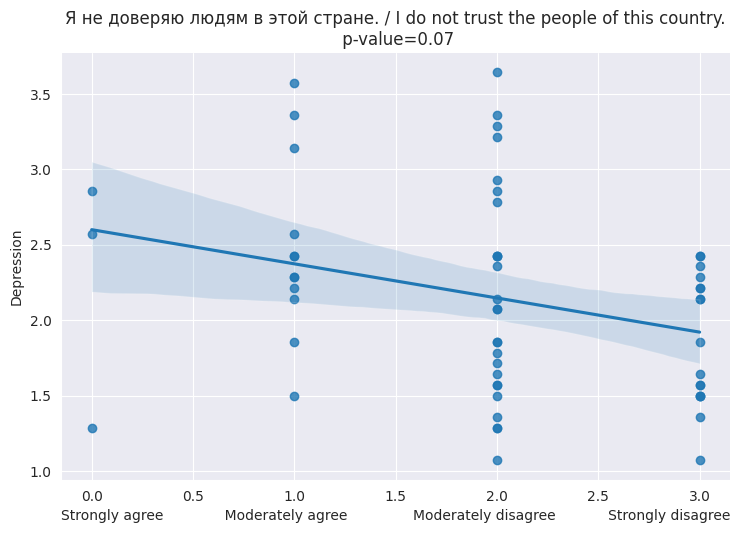

In [937]:
st = str(X.columns.tolist()[0])
seaborn.lmplot(x=st,
               y="DSM IV",
               data=DataFrame(data={st: X[st],
                                    "DSM IV": y["DSM IV"]}),
               height=5,
               aspect=1.5)
xlabel('Strongly agree              Moderately agree               Moderately disagree            Strongly disagree')
ylabel('Depression')
title(st + "\n p-value=" + str(round(p[st], 2)))

Text(0.5, 1.0, 'У меня слишком много обязанностей. / I have too many responsibilities.\n p-value=0.03')

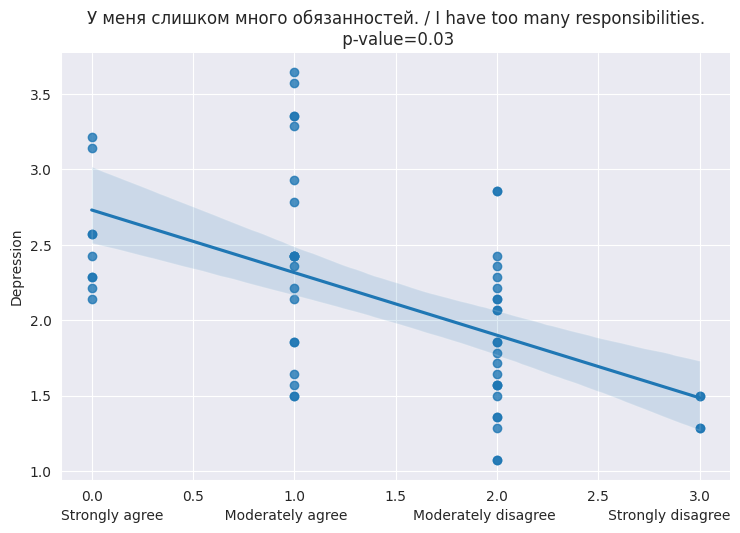

In [938]:
feature = str(X.columns.tolist()[4])
seaborn.lmplot(x=feature,
               y="DSM IV",
               data=DataFrame(data={feature: X[feature],
                                    "DSM IV": y["DSM IV"]}),
               height=5,
               aspect=1.5)
xlabel('Strongly agree              Moderately agree               Moderately disagree            Strongly disagree')
ylabel('Depression')
title(feature + "\n p-value=" + str(round(p[feature], 2)))

Text(0.5, 1.0, 'Я чувствую вину за то, что я оставил свою семью. / I feel guilty for having left my family.\n p-value=0.08')

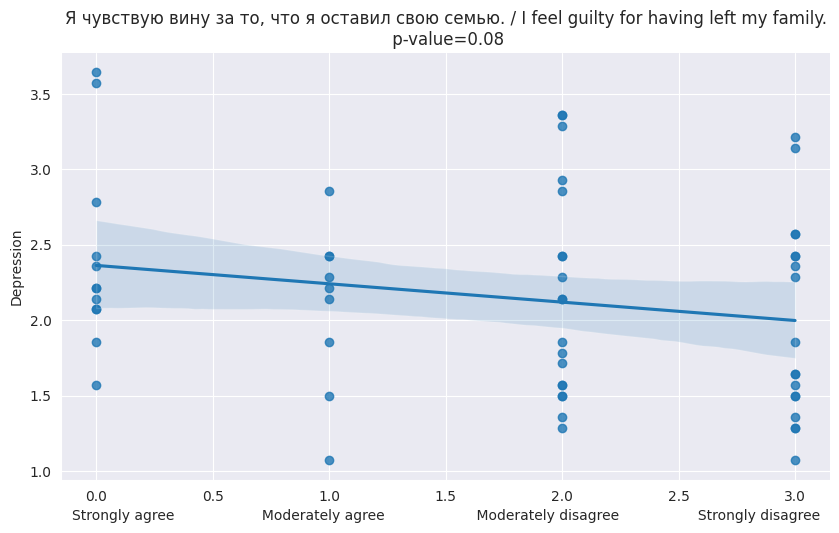

In [939]:
feature = str(X.columns.tolist()[13])
seaborn.lmplot(x=feature,
               y="DSM IV",
               data=DataFrame(data={feature: X[feature],
                                    "DSM IV": y["DSM IV"]}),
               height=5,
               aspect=1.7)
xlabel('Strongly agree                    Moderately agree                     Moderately disagree                  Strongly disagree')
ylabel('Depression')
title(feature + "\n p-value=" + str(round(p[feature], 2)))

# Stepwise Regression Implementation
## Step 6: Perform Stepwise Regression


In [940]:
# Initialize a linear regression model
lr = sklearn.linear_model.LinearRegression()

# Use SFS to perform stepwise feature selection
sfs = sklearn.feature_selection.SequentialFeatureSelector(lr, n_features_to_select=14, direction='backward', cv=5)
sfs.fit(X, y)

# Print the selected feature names
feature_names = sfs.get_feature_names_out()

## Step 7: Evaluate the Model with Selected Features

In [941]:
# Select the top features based on the selected indices
X_sfs = X.loc[:, feature_names]

In [942]:
# let add constant to X for intercept calculation
X_incl_const_sfs: DataFrame = add_constant(data=X_sfs)
# let create model for  Ordinary Least Squares (OLS)
model_sfs: statsmodels.regression.linear_model.OLS = statsmodels.regression.linear_model.OLS(endog=y, exog=X_incl_const_sfs)
# let fit model
results_sfs: statsmodels.regression.linear_model.RegressionResultsWrapper = model_sfs.fit()
print(f"Coefficient of determination: {round(results_sfs.rsquared_adj, 2)}")  # Adjusted R-squared
print(f"p-value (F-statistic): {round(results_sfs.f_pvalue, 6)}")  # p-value (F-statistic)

Coefficient of determination: 0.56
p-value (F-statistic): 2e-06


In [943]:
results_sfs.pvalues.rename('p-value')

const                                                                                                                                                                                 0.00
Я не доверяю людям в этой стране. / I do not trust the people of this country.                                                                                                        0.03
Я скучаю по атмосфере моего родного города (села). / I miss the atmosphere of my hometown.                                                                                            0.00
Социум постоянно напоминает мне, что я иммигрант. / Society constantly reminds you that you are an immigrant.                                                                         0.02
У меня слишком много обязанностей. / I have too many responsibilities.                                                                                                                0.00
Меня беспокоит, что я не смогу дать моим детям образование, котор

# Table of features with less than 0.07 p-value in APA format.

In [944]:
estimate = results_sfs.params.rename('Estimate').to_frame()
ci = results_sfs.conf_int(alpha=0.05, cols=None).rename(columns={0: 'LL', 1: 'UL'})
se = results_sfs.bse.rename('SE')
p = results_sfs.pvalues.rename('p')
p = p[p <= 0.07]
options.display.float_format = '{:,.2f}'.format
estimate.join(other=[se, ci, p], on=None, how='inner')

,Estimate,SE,LL,UL,p
const,3.20,0.35,2.50,3.90,0.00
Я не доверяю людям в этой стране. / I do not trust the people of this country.,-0.17,0.07,-0.32,-0.02,0.03
Я скучаю по атмосфере моего родного города (села). / I miss the atmosphere of my hometown.,-0.28,0.08,-0.44,-0.12,0.00
"Социум постоянно напоминает мне, что я иммигрант. / Society constantly reminds you that you are an immigrant.",0.21,0.08,0.04,0.38,0.02
У меня слишком много обязанностей. / I have too many responsibilities.,-0.39,0.09,-0.58,-0.20,0.00
"Меня беспокоит, что я не смогу дать моим детям образование, которое будет соответствовать моей культуре. / It worries me that I cannot educate my children according to my culture.",0.16,0.08,-0.01,0.33,0.06
"Я чувствую, что я не принадлежу к этому обществу. / I feel that I do not belong to this society.",-0.17,0.09,-0.35,0.01,0.07
"Я чувствую вину за то, что я оставил свою семью. / I feel guilty for having left my family.",-0.20,0.07,-0.35,-0.05,0.01
Я часто чувствую себя напряженным. / I frequently feel tense.,0.25,0.11,0.03,0.48,0.03
Я чувствую давление от жителей этой страны принять их стиль жизни. / I feel pressured by the people of this country to adopt their lifestyle.,0.33,0.11,0.10,0.55,0.01
